# Notebook to develop and test the ABC Rejection on DAP cell model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from tqdm import tqdm

from delfi.distribution import Uniform
from dap.utils import obs_params_gbar, syn_current
from dap.dap_sumstats_moments import DAPSummaryStatsMoments
from dap import DAPcython
from dap.dap_simulator import DAPSimulator

In [2]:
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

### General Settings Pick

In [3]:
n_samples = 100
n_summary = 17
dt = 0.01

### Get current

In [4]:
I, t, t_on, t_off = syn_current(duration=70, dt=dt, t_on=15, t_off=20, amp=3.1)
params, labels = obs_params_gbar(reduced_model=True)
params[0]

0.01527

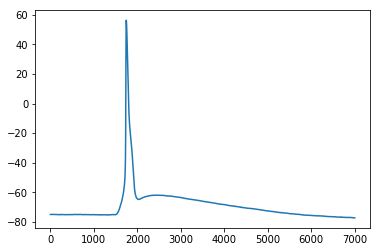

In [5]:
dap = DAPcython(-75, params*10)
U = dap.simulate(dt, t, I)
plt.plot(U);

### Set up the model

In [6]:
sim = DAPSimulator(I, dt, -75, dim_param=1)
stats = DAPSummaryStatsMoments(t_on, t_off, n_summary=n_summary)

### Setup Priors

In [7]:
prior_min = np.array([0])
prior_max = np.array([5])
prior_unif = Uniform(lower=prior_min, upper=prior_max)

In [8]:
params = prior_unif.gen(n_samples=2000)
params

array([[ 0.25],
       [ 3.89],
       [ 3.95],
       ...,
       [ 3.94],
       [ 2.93],
       [ 0.98]])

### generate desired data

In [9]:
U = dap.simulate(dt, t, I)
y_o = {'data': U.reshape(-1),
       'time': t,
       'dt': dt,
       'I': I}
y = stats.calc([y_o])
y

array([[-75.15,  0.06, -69.18,  1.00,  0.49,  0.17,  0.15,  0.18,
         1078.68,  1.64,  4.86,  12.99,  26.49,  0.20,  1.59,  0.67]])

In [10]:
sum_stats = zscore(y, axis=1)
sum_stats

array([[-0.52, -0.23, -0.50, -0.23, -0.23, -0.23, -0.23, -0.23,  3.85,
        -0.23, -0.21, -0.18, -0.13, -0.23, -0.23, -0.23]])

array([[-33.31,  26.94, -33.25,  18.00, -0.19, -0.65,  0.18,  0.68,
         691.17,  1.19,  3.16,  6.40,  713.02,  0.91,  2.57,  4.45]])

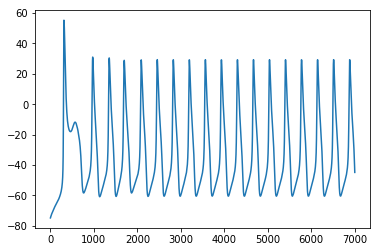

In [11]:
dap2 = DAPcython(-75, np.array([.3]))
U2 = dap2.simulate(dt, t, I)
plt.plot(U2);

y_o2 = {'data': U2.reshape(-1),
       'time': t,
       'dt': dt,
       'I': I}
y2 = stats.calc([y_o2])
y2

array([[-21.62,  6.60, -23.37,  21.00, -0.48, -0.34,  0.91, -0.59,
         388.29,  0.44,  1.99,  1.93,  443.90,  0.50,  1.95,  2.13]])

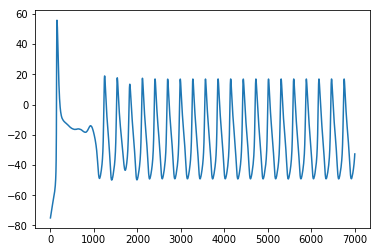

In [12]:
dap2 = DAPcython(-75, np.array([.47]))
U2 = dap2.simulate(dt, t, I)
plt.plot(U2);

y_o2 = {'data': U2.reshape(-1),
       'time': t,
       'dt': dt,
       'I': I}
y2 = stats.calc([y_o2])
y2

## Repeat for 1000 in a loop

In [13]:
n_samples = 1000
eps = 1

In [14]:
params = prior_unif.gen(n_samples=n_samples)
params_std = params.std()
params_mean = params.mean()

In [15]:
norms = []

for p in tqdm(params):
#     print(p)
    x_o = sim.gen_single(p)
    y_obs = stats.calc([x_o])    
    obs_zt = zscore(y_obs, axis=1)
    dist_sum_stats = np.linalg.norm((sum_stats-obs_zt),axis=1)

    norms.append(dist_sum_stats)

100%|██████████| 1000/1000 [03:33<00:00,  4.69it/s]


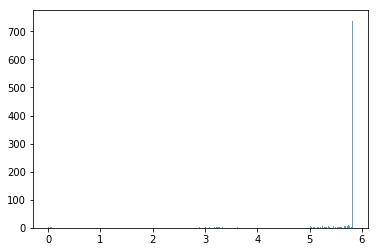

In [16]:
N1 = np.array(norms)
plt.hist(x=N1, bins='auto', alpha=0.7, rwidth=0.85);

## Sort the stuff

In [17]:
scores = N1.transpose()[0]
arg_sorted = np.argsort(scores)

In [18]:
# rejection criterion
percent_accept = 10
percent_criterion = int(len(arg_sorted)*percent_accept/100)

In [19]:
# rejection (or more positively, acceptance) of the z-scored parameters 'params' and inverse z-scoring of the accepted parameters
params_accept = params[arg_sorted[0:percent_criterion],:]*params_std + params_mean

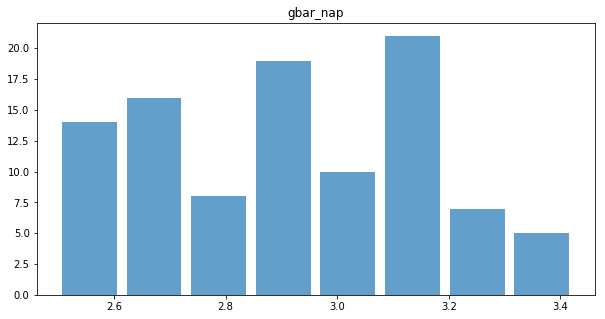

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax.set_title(labels[0]);

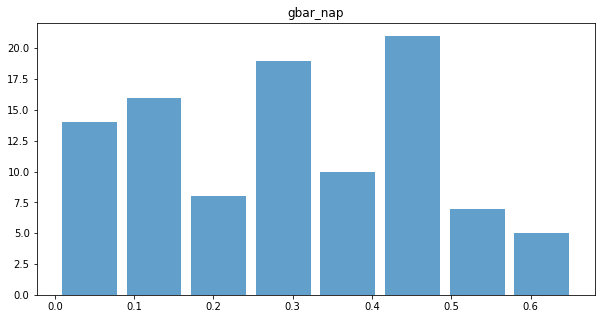

In [21]:
params_accept = params[arg_sorted[0:percent_criterion],:]
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax.set_title(labels[0]);

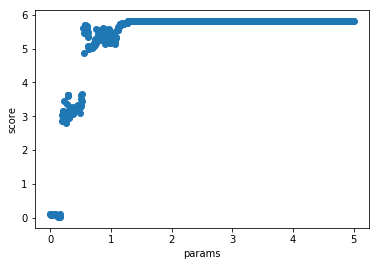

In [22]:
plt.scatter(params, scores)
plt.xlabel('params')
plt.ylabel('score');

## Repeat for 5000 in a loop

In [23]:
n_samples = 5000
eps = 1

In [24]:
params = prior_unif.gen(n_samples=n_samples)
params_std = params.std()
params_mean = params.mean()

In [25]:
norms = []

for p in tqdm(params):
    x_o = sim.gen_single(p)
    y_obs = stats.calc([x_o])    
    obs_zt = zscore(y_obs, axis=1)
    dist_sum_stats = np.linalg.norm((sum_stats-obs_zt),axis=1)

    norms.append(dist_sum_stats)

100%|██████████| 5000/5000 [18:32<00:00,  4.49it/s]


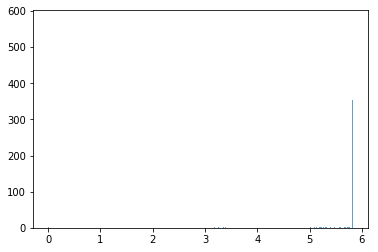

In [48]:
N5 = np.array(norms)
plt.hist(x=N5, bins='auto', alpha=0.7, rwidth=0.85);

## Sort the stuff

In [40]:
scores = N5.transpose()[0]
arg_sorted = np.argsort(scores)

In [41]:
# rejection criterion
percent_accept = 1
percent_criterion = int(len(arg_sorted)*percent_accept/100)

In [42]:
# rejection (or more positively, acceptance) of the z-scored parameters 'params' and inverse z-scoring of the accepted parameters
params_accept = params[arg_sorted[0:percent_criterion],:]*params_std + params_mean
# params_accept = params[arg_sorted[0:percent_criterion],:]
params_accept = params[arg_sorted[0:percent_criterion],:]*params_mean + params_std

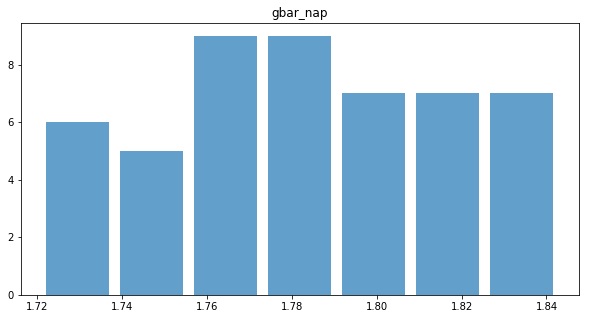

In [43]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(x=params_accept[:], bins='auto', alpha=0.7, rwidth=0.85);
ax.set_title(labels[0]);

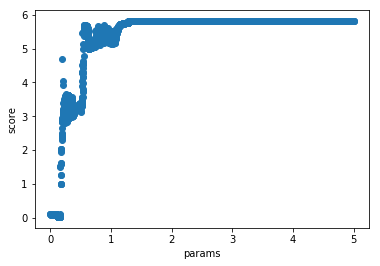

In [44]:
plt.scatter(params, scores)
plt.xlabel('params')
plt.ylabel('score');

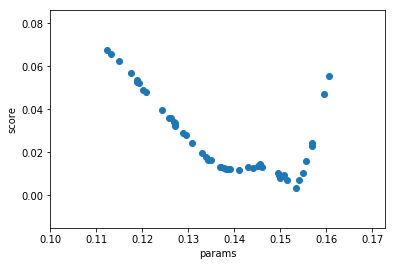

In [45]:
p = params[arg_sorted[0:percent_criterion],:]
s = scores[arg_sorted[0:percent_criterion]]

plt.scatter(p, s)
plt.xlabel('params')
plt.ylabel('score');

In [46]:
p[0]

array([ 0.15])

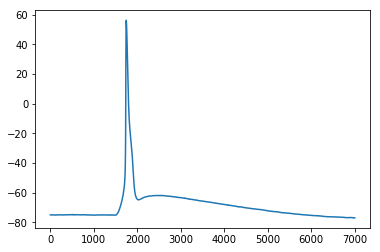

In [47]:
dap = DAPcython(-75, p[0])
U = dap.simulate(dt, t, I)
plt.plot(U);